In [ ]:
import torch
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as plt
from torchvision.transforms import v2
from torchvision.io import decode_image
from torchvision.io import ImageReadMode
from einops import rearrange
from segdac.networks.image_segmentation_models.grounded_efficientvit_sam import (
    GroundedEfficientVitSam,
)
seed = 123

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

/home/mila/b/browna/.conda/envs/maniskill3_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded image :torch.Size([3, 512, 512]) cuda:0


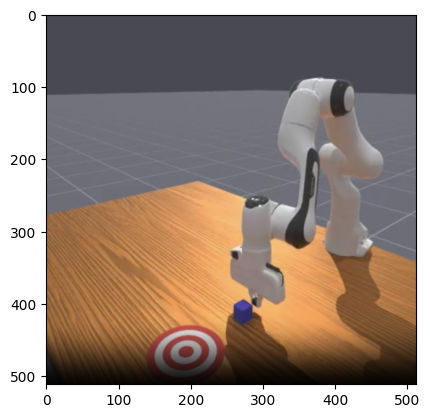

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

image_path = "images/push.png"

image = decode_image(image_path, mode=ImageReadMode.RGB).to(device)
image_size = 512

env_transforms = v2.Compose(
    [
        v2.Resize(size=(image_size, image_size)),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)
image = env_transforms(image)
print(f"Loaded image :{image.shape} {image.device}")

fig, ax = plt.subplots()
ax.imshow(rearrange(image, "c h w ->h w c").cpu().numpy())

In [3]:
tags = ["robot", "small cube", "target", "table"]
segmenter = GroundedEfficientVitSam(
    device=device,
    grounding_text_tags=tags,
    object_detector_weights_path="../weights/yolov8s-worldv2.pt",
    object_detection_confidence_threshold=0.0001,
    object_detection_iou_threshold=0.01,
    segmenter_model_name="efficientvit-sam-l0",
    segmenter_weights_path="../weights/efficientvit_sam_l0.pt",
    masks_post_process_kernel_size=9,
    compile_mode="max-autotune",
    return_sam_embeddings=True
)

In [4]:
pred_imgs = torch.stack([image])
pred_imgs.shape

torch.Size([1, 3, 512, 512])

In [5]:
a = time.perf_counter()
segments_data, sam_embeddings = segmenter.segment(pred_imgs)
b = time.perf_counter()
b - a

0.6079059522598982

In [6]:
segments_data

TensorDict(
    fields={
        absolute_segment_ids: Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.int64, is_shared=True),
        binary_masks: Tensor(shape=torch.Size([4, 1, 512, 512]), device=cuda:0, dtype=torch.uint8, is_shared=True),
        coords: TensorDict(
            fields={
                masks_absolute_bboxes: Tensor(shape=torch.Size([4, 4]), device=cuda:0, dtype=torch.int64, is_shared=True),
                masks_normalized_bboxes: Tensor(shape=torch.Size([4, 4]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([4]),
            device=cuda:0,
            is_shared=True),
        image_ids: Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.int64, is_shared=True),
        relative_segment_ids: Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.int64, is_shared=True),
        rgb_segments: Tensor(shape=torch.Size([4, 3, 512, 512]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.S

In [7]:
sam_embeddings.shape

torch.Size([1, 256, 64, 64])

In [8]:
nb_mask_x_idx_per_embed_patch = segmenter.segmenter_image_size // sam_embeddings.shape[-1]
nb_mask_y_idx_per_embed_patch = segmenter.segmenter_image_size // sam_embeddings.shape[-2]
nb_mask_x_idx_per_embed_patch, nb_mask_y_idx_per_embed_patch

(8, 8)

In [115]:
a = time.perf_counter()
embeddings_masks_pixels_count = torch.nn.functional.conv2d(
    input=segments_data['binary_masks'].float(), 
    weight=torch.ones(
        size=(1, 1, nb_mask_x_idx_per_embed_patch, nb_mask_y_idx_per_embed_patch),
        dtype=torch.float32,
        device=segments_data.device
    ),
    bias=None, 
    stride=(nb_mask_x_idx_per_embed_patch, nb_mask_y_idx_per_embed_patch), 
    padding=0
)
b = time.perf_counter()
b-a

0.0013829972594976425

In [12]:
embeddings_masks_pixels_count.shape

torch.Size([4, 1, 64, 64])

In [11]:
segments_data['binary_masks'].shape

torch.Size([4, 1, 512, 512])

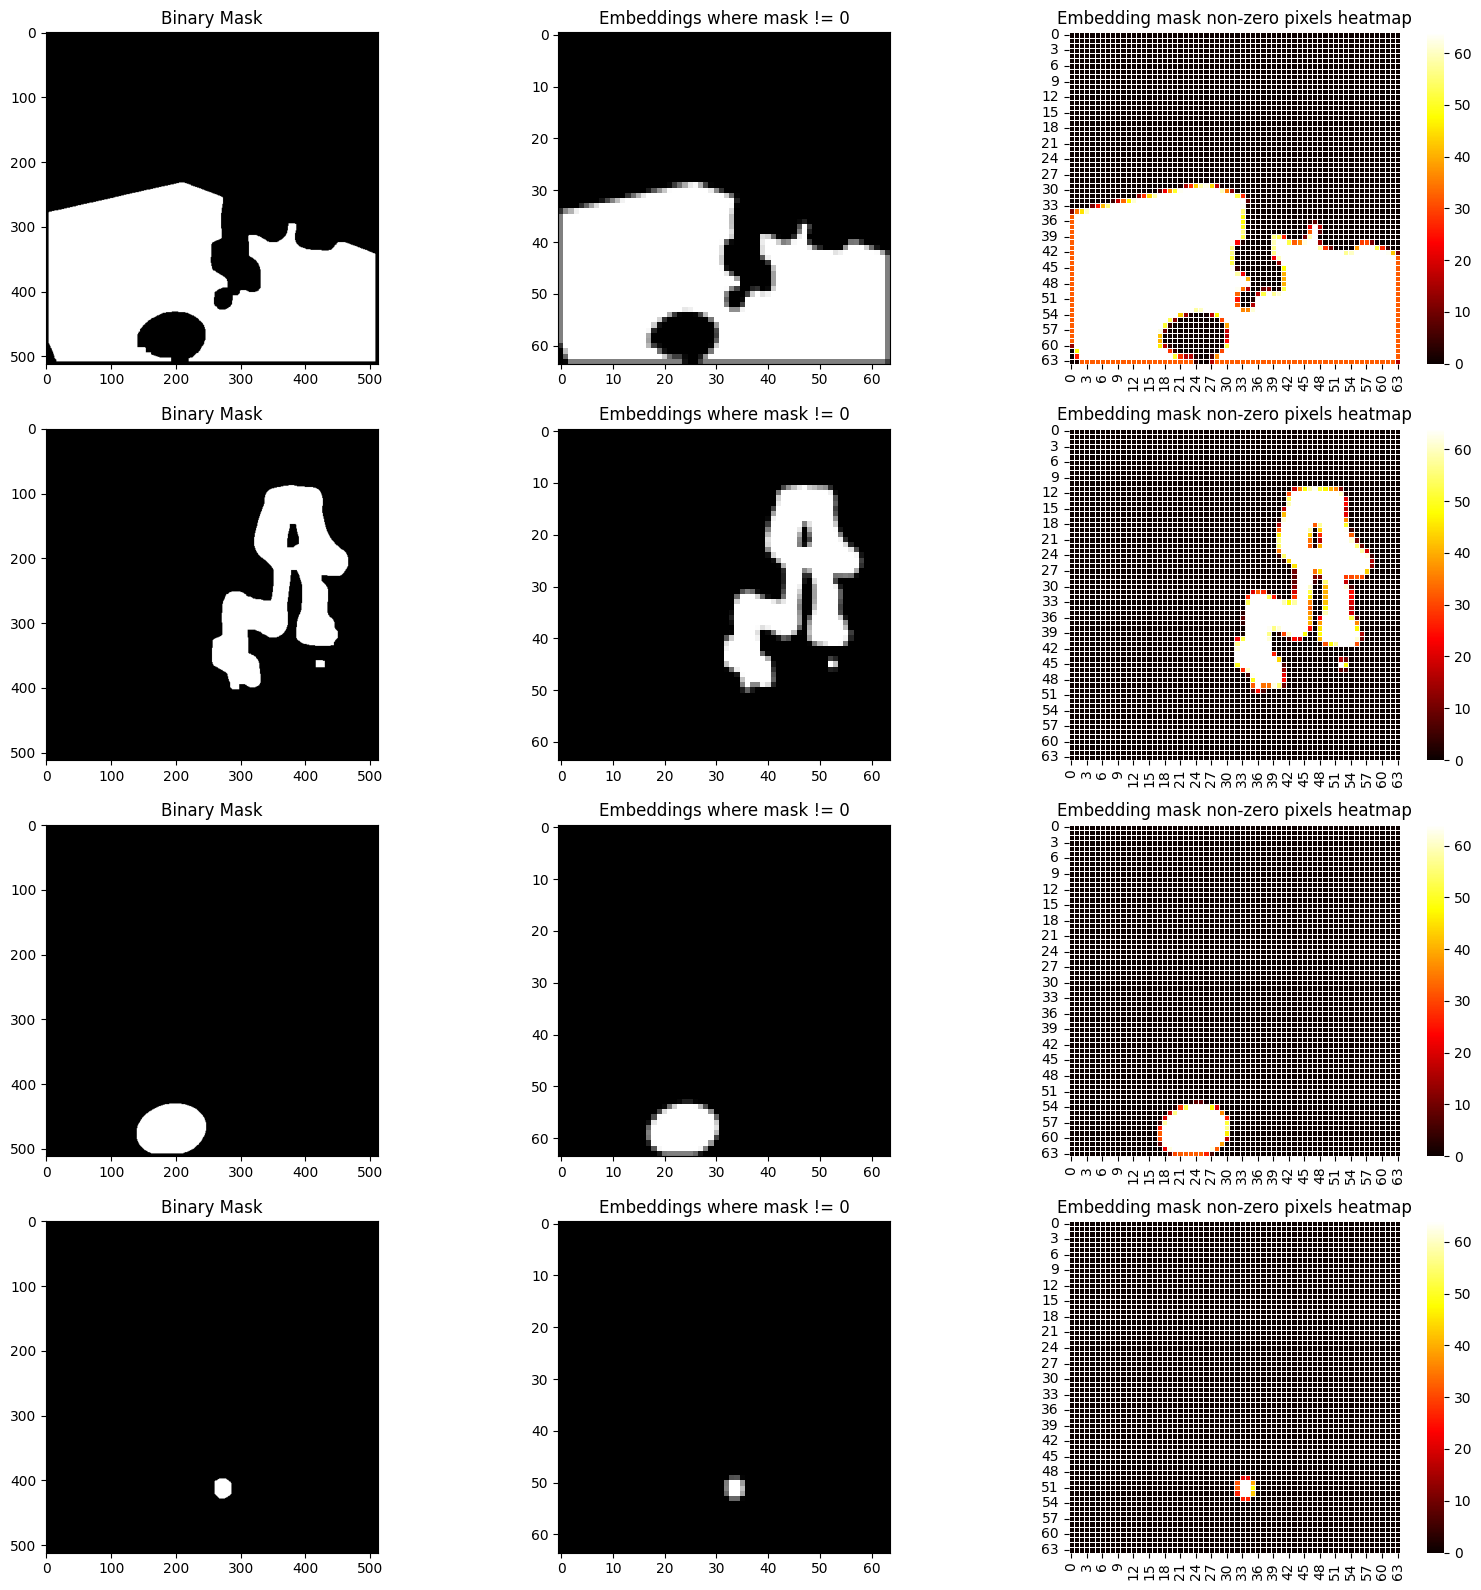

In [49]:
nb_segments = segments_data['binary_masks'].shape[0]
fig, ax = plt.subplots(
    nrows=nb_segments,
    ncols=3,
    figsize=(16, nb_segments*4)
)

plt.subplots_adjust(wspace=0, hspace=0)

for segment_index in range(nb_segments):
    mask = segments_data['binary_masks'][segment_index].squeeze().cpu()
    count = embeddings_masks_pixels_count[segment_index].squeeze().cpu()
    
    ax[segment_index, 0].imshow(mask, cmap='binary_r')
    ax[segment_index, 0].set_aspect('equal')
    ax[segment_index, 0].set_title("Binary Mask")

    ax[segment_index, 1].imshow(count, cmap='binary_r')
    ax[segment_index, 1].set_aspect('equal')
    ax[segment_index, 1].set_title("Embeddings where mask != 0")

    sns.heatmap(
        count,
        ax=ax[segment_index, 2],
        cmap='hot',
        cbar=True,
        square=True,
        linewidths=0.5
    )
    ax[segment_index, 2].set_title("Embedding mask non-zero pixels heatmap")

fig.tight_layout()
plt.show()

In [52]:
embeddings_masks_pixels_count.shape

torch.Size([4, 1, 64, 64])

In [53]:
sam_embeddings.shape

torch.Size([1, 256, 64, 64])

In [109]:
a = time.perf_counter()
segments_embeddings = []
nb_segments = embeddings_masks_pixels_count.shape[0]
min_non_zero_pixels_in_embedding_cell = 1
sam_embeddings_selection_mask = embeddings_masks_pixels_count.squeeze(1) >= min_non_zero_pixels_in_embedding_cell

for segment_index in range(nb_segments):
    image_id = segments_data['image_ids'][segment_index]
    image_sam_embeddings = sam_embeddings[image_id]
    segment_embeddings = image_sam_embeddings[:, sam_embeddings_selection_mask[segment_index]]
    segment_embeddings = segment_embeddings.mean(axis=1)
    segments_embeddings.append(segment_embeddings)

segments_embeddings = torch.stack(segments_embeddings)
b = time.perf_counter()
print(f"Time : {b-a}")
print(f"segments_embeddings: {segments_embeddings.shape}")

Time : 0.0028949398547410965
segments_embeddings: torch.Size([4, 256])


In [116]:
from segdac.networks.segments_encoders.sam_encoder_segments_encoder import SamEncoderSegmentsEncoder

In [118]:
seg_encoder = SamEncoderSegmentsEncoder(
    segmenter_image_size=segmenter.segmenter_image_size,
    min_pixels=1
).to(device)

In [119]:
seg_encoder_output = seg_encoder(segments_data, sam_embeddings)

In [122]:
seg_encoder_output

TensorDict(
    fields={
        embeddings: Tensor(shape=torch.Size([4, 256]), device=cuda:0, dtype=torch.float32, is_shared=True),
        image_ids: Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.int64, is_shared=True),
        is_latent_tokens: Tensor(shape=torch.Size([4]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([4]),
    device=cuda:0,
    is_shared=True)